Author : Hind Bakkali - M1-IRIFS
# Coding project - Picture enhancement
## Project statement
Write code that automatically enhances a photograph.

"Enhance" may mean a lot of different things, and we encourage you to be creative in which enhancements you want to implement.

Some possibilities include (not an exhaustive list):

* Noise reduction
* Auto-level
* Gamma correction (with gamma provided by the user or automatically determined from the image histogram)
* Increase colour saturation
* ...


## Project implementation

Let's start by importing all the packages/images needed and defining the histograms functions.

In [16]:
# import libraries & functions
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.color import rgb2hsv,gray2rgb,hsv2rgb
from skimage.filters import median
from skimage.morphology import disk

# import images
im_astronaut = imread('astronaut_noisy.jpg')
im_brain = imread('mri_brain.jpg')
im_etretat = imread('etretat.jpg')
im_nyc = imread('nyc.jpg')
im_walking = imread('walking.jpg')
im_zebra = imread('zebra.jpg')

# histograms
def norm_hist(im):
    hist,bins = np.histogram(im.flatten(),range(256))  # histogram is computed on a 1D distribution --> flatten()
    return 1.*hist/np.sum(hist) # normalized histogram
def cumul_hist(im):
    nh = norm_hist(im)
    return np.append(np.array(0),np.cumsum(nh))

**Enhancement 0 : "negative" effect**

This is a simple operation : inverting an image. To do so, we use a look-up table.

Inverting an image can be useful for analyzing medical images. For example, we can see that the tumor
in the "mri_brain" image is more visible on the inverted image.

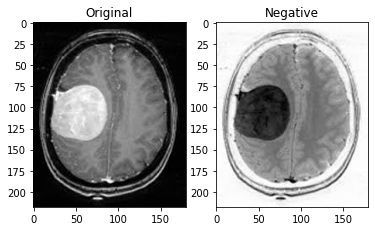

In [17]:
def negative(im):
    inverse_lut = np.arange(255,-1,-1)
    return inverse_lut[im]

# example with the brain MRI image
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im_brain)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(negative(im_brain))
plt.title("Negative")
plt.show()

**Enhancement 1 : change luminosity/contrast**

To reinforce the contrast of the image, we use a Gamma correction :

$$I_{out} = A \: I_{in}^{\gamma}$$

with A = $255^{1-\gamma}$

$\gamma$ <1 : luminosity increases, the image gets brighter (compression).

$\gamma$ >1 : luminosity decreases, the image gets darker (expansion).


<Figure size 432x288 with 0 Axes>

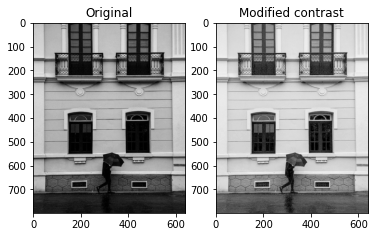

In [18]:
def gamma(im, gamma):
    res = im.copy()
    lut = np.power(np.arange(256),gamma) * np.power(255.,1-gamma)
    # grayscale image (1 color channel)
    if len(im.shape) == 2:
        res = lut[res]
    # colored image (3 color channels)
    elif len(im.shape) == 3:
        res[:,:,0] = lut[res[:,:,0]]
        res[:,:,1] = lut[res[:,:,1]]
        res[:,:,2] = lut[res[:,:,2]]
    return res.astype("uint8")

plt.gray()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im_walking)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(gamma(im_walking, 0.5))
plt.title("Modified contrast")
plt.show()

**Enhancement 2 : auto-level**

What it does is map the image to its full dynamic scale.
We take the highest and lowest values in the image - in each colour channel
if there are any - and set them as the maximum and minimum values,
redistributing all the other values :

$I_{out} = 255 * (g_{in}-g_{min})/(g_{max}-g_{min})$

The function defined below allows to choose a percentile to determine the
2 thresholds (min and max).

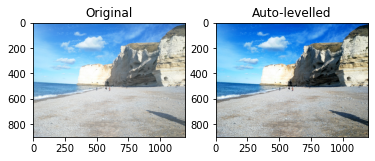

In [19]:
def auto_level(im, percentile):
    res = im.copy()
    min = 0
    max = 255
    """determine min and max thresholds (with a percentile margin)"""
    hist = cumul_hist(res)
    # find min
    for i in range(256):
        if hist[i] > percentile: break
        else: min = i
    # find max
    for i in range(256):
        if hist[255-i] < 1 - percentile: break
        else: max = 255-i
    """compute auto-level LUT based on these thresholds"""
    lut = np.arange(256)
    lut[:min] = 0
    lut[max:] = 255
    lut[min:max] = 255 * ((lut[min:max] - min)/(max-min))
    """compute auto-level on the image (gray scale or colored)"""
    # grayscale image (1 color channel)
    if len(im.shape) == 2:
        res = lut[res]
    # colored image (3 color channels)
    elif len(im.shape) == 3:
        res[:,:,0] = lut[res[:,:,0]]
        res[:,:,1] = lut[res[:,:,1]]
        res[:,:,2] = lut[res[:,:,2]]
    return res.astype("uint8")

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im_etretat)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(auto_level(im_etretat, 0.02))
plt.title("Auto-levelled")
plt.show()

**Enhancement 3 : change saturation**

A good enhancement to add for colored images is the possibility to change saturation,
making the colors more vibrant. To do so, we convert the image to HSV and change the
"saturation" channel, then convert back to RGB.

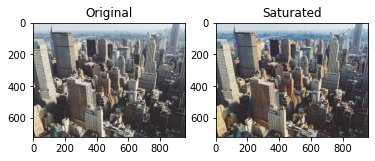

In [20]:
def saturation(im, vibrance):
    res = im.copy()
    # grayscale image : convert to RGB first
    if len(im.shape) == 2:
        res = gray2rgb(res)
    # convert to HSV
    res = rgb2hsv(res)
    # change saturation and back to RGB
    res[:,:,1]= vibrance * res[:,:,1]
    return (hsv2rgb(res) * 255).astype("uint8") # back to int since multiplied by float

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im_nyc)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(saturation(im_nyc, 1.5))
plt.title("Saturated")
plt.show()

**Enhancement 4 : reduce noise**

Lastly, we can reduce the noise in the image using a median filter. It allows to smooth
the image while keeping good edges (different from mean filter where borders are blurred).
The structuring element size (disk radius) should be small so that we keep a good image quality.

<Figure size 432x288 with 0 Axes>

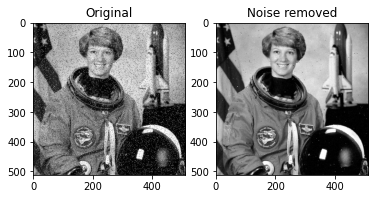

In [21]:
def median_filter(im, radius):
    res = im.copy()
    # grayscale image (1 color channel)
    if len(im.shape) == 2:
        res = median(res, disk(radius))
    # colored image (3 color channels)
    elif len(im.shape) == 3:
        res[:,:,0] = median(res[:,:,0], disk(radius))
        res[:,:,1] = median(res[:,:,1], disk(radius))
        res[:,:,2] = median(res[:,:,2], disk(radius))
    return res.astype("uint8")

plt.gray()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im_astronaut)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(median_filter(im_astronaut, 1))
plt.title("Noise removed")
plt.show()


**Final function**

All these filters are combined in the function below.

In [22]:
def enhancement(im, contrast_gamma, autolevel_percentile, saturation_vibrance, median_radius):
    res = im.copy()
    res = gamma(res, contrast_gamma)
    res = auto_level(res, autolevel_percentile)
    res = saturation(res, saturation_vibrance)
    res = median_filter(res, median_radius)
    return res

**Enhanced images**

All these filters are combined in the function below.

<Figure size 432x288 with 0 Axes>

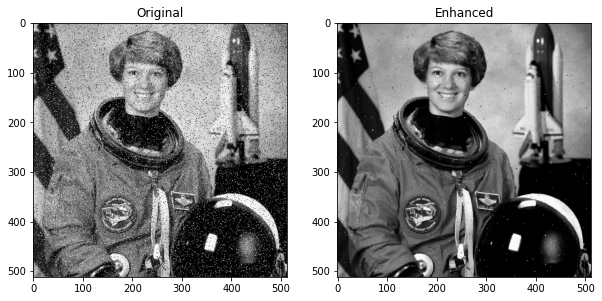

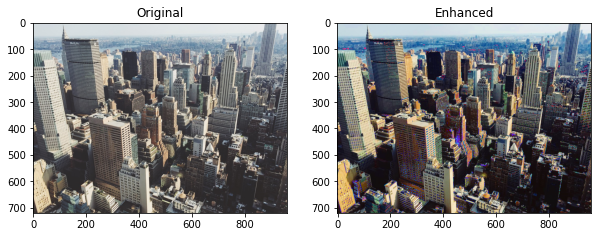

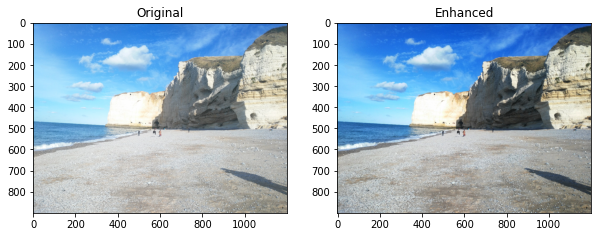

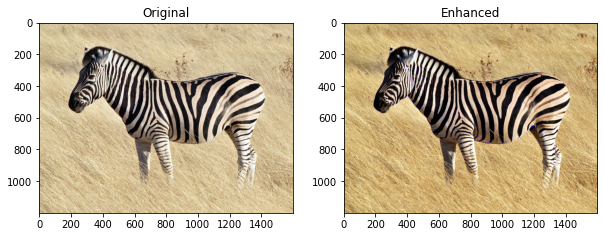

In [23]:
# Examples
plt.gray()
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im_astronaut)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(enhancement(im_astronaut, 1.3, 0.01, 1.2, 1))
plt.title("Enhanced")
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im_nyc)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(enhancement(im_nyc, 1.1, 0.005, 2, 0))
plt.title("Enhanced")
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im_etretat)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(enhancement(im_etretat, 1.5, 0, 1, 1))
plt.title("Enhanced")
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im_zebra)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(enhancement(im_zebra, 1.3, 0.01, 1.2, 1))
plt.title("Enhanced")
plt.show()